In [1]:
from google.colab import drive
drive.mount('/content/drive/')
%cd /content/drive/My Drive/Kotina/model/
root_path = '/content/drive/My Drive/Kotina/'

Mounted at /content/drive/
/content/drive/My Drive/Kotina/model


In [1]:
!pip install "torch==1.31.1" "numpy==1.26.5" "thinc==8.3.4" "monai==1.2.0" "nibabel==4.0.2" "torchvision==0.15.2" "torchaudio==2.0.2"

ERROR: Could not find a version that satisfies the requirement torch==1.31.1 (from versions: 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2, 2.3.0, 2.3.1, 2.4.0, 2.4.1, 2.5.0, 2.5.1, 2.6.0, 2.7.0)
ERROR: No matching distribution found for torch==1.31.1


In [5]:
!pip install numpy==1.23.5

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 117.8 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 1.26.0
    Uninstalling numpy-1.26.0:
      Successfully uninstalled numpy-1.26.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.23.5 which is incompatible.
treescope 0.1.9 requires numpy>=1.25.2, but you have numpy 1.23.5 which is incompatible.
pymc 5.22.0 requires numpy>=1.25.0, but you have numpy 1.23.5 which is incompatible.
db-dtypes 1.4.3 requires numpy>=1.24.0, but you have numpy 1.23.5 which is incompatible.
chex 0.1.89 requires numpy>=1.24.1, but you have numpy 1.23.5 which is incompatible.
albumentations 2.0.6 requires numpy>=1.24.4, but you have numpy 1.23.5 which is incompatible.
blosc2 3.3.2 requires numpy>=1.26, but you have numpy 1.23.5 which is i

In [2]:
# !python -c "import monai" #|| pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"

from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImage,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
    DivisiblePadd,
    RandAffined,
    RandRotated,
    RandGaussianNoised,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss, DiceCELoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
from torch.utils.data import ConcatDataset
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob
from datetime import datetime

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
# data_dir = f"{root_path}datasets_nii/"
# train_images = sorted(glob.glob(os.path.join(data_dir, "photos/", "*.nii")))
# train_labels = sorted(glob.glob(os.path.join(data_dir, "masks/", "*.nii")))
# data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
# train_files, val_files = data_dicts[:-1], data_dicts[-1:] # 2 train and 1 validation data_dicts[:-1], data_dicts[-1:]
# train_files, val_files
data_dir = "/content/drive/My Drive/kaggle_ds/"
train_images = sorted(glob.glob(os.path.join(data_dir, "Train", "*/*.nii")))
train_labels = sorted(glob.glob(os.path.join(data_dir, "Train_labels", "*/*.nii")))
data_dicts = [{"image": image_name, "label": label_name} for image_name, label_name in zip(train_images, train_labels)]
train_files, val_files = data_dicts[:-4], data_dicts[-4:] # 16 train and 4 validation
train_files, val_files

([{'image': '/content/drive/My Drive/kaggle_ds/Train/la_003.nii/la_003.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_003.nii/la_003.nii'},
  {'image': '/content/drive/My Drive/kaggle_ds/Train/la_004.nii/la_004.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_004.nii/la_004.nii'},
  {'image': '/content/drive/My Drive/kaggle_ds/Train/la_005.nii/la_005.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_005.nii/la_005.nii'},
  {'image': '/content/drive/My Drive/kaggle_ds/Train/la_007.nii/la_007.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_007.nii/la_007.nii'},
  {'image': '/content/drive/My Drive/kaggle_ds/Train/la_009.nii/la_009.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_009.nii/la_009.nii'},
  {'image': '/content/drive/My Drive/kaggle_ds/Train/la_010.nii/la_010.nii',
   'label': '/content/drive/My Drive/kaggle_ds/Train_labels/la_010.nii/la_010.nii'},
  {'image': '/content/drive/

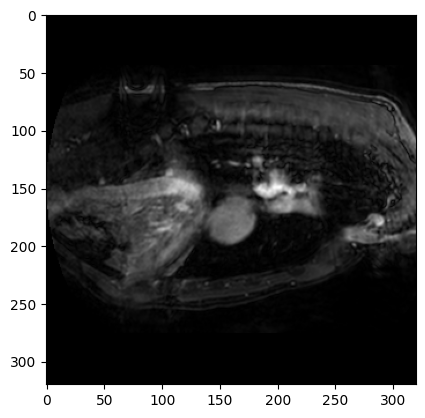

In [ ]:
import matplotlib
from matplotlib import pylab as plt
import nibabel as nib
from nibabel import nifti1
from nibabel.viewers import OrthoSlicer3D
img_path='/content/drive/My Drive/kaggle_ds/Train/la_026.nii/la_026.nii'
img=nib.load(img_path)
# print(img.dataobj.shape)
# width,height,queue=img.dataobj.shape
# OrthoSlicer3D(img.dataobj[:,:,:]).show()
plt.imshow(img.dataobj[:,:,-10],cmap='gray')

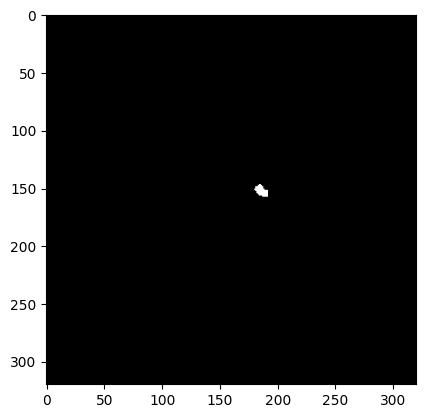

In [ ]:
img_path='/content/drive/My Drive/kaggle_ds/Train_labels/la_026.nii/la_026.nii'
img=nib.load(img_path)
width,height,queue=img.dataobj.shape
# OrthoSlicer3D(img.dataobj[:,:,0]).show()
plt.imshow(img.dataobj[:,:,-10],cmap='gray')

In [5]:
from monai.transforms import (Transposed, CenterSpatialCropd, SpatialPadd, AddChanneld, EnsureTyped)

In [6]:
import numpy as np

In [16]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        # Transposed(keys=["image", "label"], indices = (2,0,1)),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16),
    EnsureTyped(keys=["image", "label"])
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        # Transposed(keys=["image", "label"], indices = (2,0,1)),
        EnsureChannelFirstd(keys=["image", "label"]),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        DivisiblePadd(["image", "label"], 16),
    EnsureTyped(keys=["image", "label"])
    ]
)

augm_transforms = Compose(
    [
        RandAffined(keys=['image', 'label'], prob=0.5, translate_range=(10.0, 10.0, 10.0)),
        RandRotated(keys=['image', 'label'], prob=0.5, range_x=np.pi/12),
        RandGaussianNoised(keys='image', prob=0.5),
    ]
)

In [17]:
# 2 images -> transform
train_ds = CacheDataset(data=train_files, transform=train_transforms)

# # transform + data augmentation
augm_ds= CacheDataset(data=train_files, transform=[train_transforms, augm_transforms])

train_ds = ConcatDataset([train_ds, augm_ds])

train_loader = DataLoader(train_ds)

val_ds = CacheDataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds)

Loading dataset: 100%|██████████| 4/4 [00:02<00:00,  1.56it/s]


In [ ]:
for batch in train_loader:
  print(batch['image'].shape)

torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 224, 272, 96])
torch.Size([1, 1, 176, 272, 64])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 192, 272, 80])
torch.Size([1, 1, 176, 272, 80])
torch.Size([1, 1, 192, 272, 80])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 80])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 224, 272, 96])
torch.Size([1, 1, 176, 272, 64])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 208, 272, 96])
torch.Size([1, 1, 192, 272, 80])
torch.Size([1, 1, 176, 272, 80])
torch.Size([1, 1, 192, 272, 80])
torch.Size

In [ ]:
for batch in val_loader:
  print(batch['image'].shape)

torch.Size([1, 1, 320, 320, 128])
torch.Size([1, 1, 320, 320, 128])
torch.Size([1, 1, 320, 320, 112])
torch.Size([1, 1, 320, 320, 112])


In [20]:
# implementing the early stopping
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float('inf')

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [21]:
model = UNet(
    spatial_dims=3,
    in_channels=1, # hard labeling
    out_channels=2, # soft labeling
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    dropout =0.2,
    norm=Norm.BATCH,
).to(device)
loss_function = DiceCELoss(to_onehot_y=True, softmax = True)
optimizer = torch.optim.AdamW(model.parameters(), 1e-4, amsgrad = True)
early_stopper = EarlyStopper(patience=3, min_delta=0.3)

In [22]:
total_time = 0
max_epochs = 20
val_interval = 1 #not a large dataset, so it is fine
print_interval = 20
epoch_loss_values = []
losses_validation = []

for epoch in range(max_epochs):
    start_time = datetime.now()
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train() # tell Dropout and BatchNorm to work bcs it is training
    epoch_loss = 0
    step = 0

    # getting data for each batch
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )

        # normal pipeline
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()

        #loss.item -> each batch loss
        epoch_loss += loss.item()
        if (epoch) % print_interval == 0:
            print(f"{step}/{len(train_ds) // train_loader.batch_size}, " f"train_loss: {loss.item():.4f}")

    # measuring time
    actual_time = datetime.now() - start_time
    print(f"time to train this epoch: {actual_time}")
    total_time += actual_time.total_seconds()
    # saving the loss for the actual epoch
    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")


    if (epoch + 1) % val_interval == 0:
        model.eval() # tell Dropout and BatchNorm to "turn off" bcs I am evaluating the model
        with torch.no_grad():
            loss_val = 0
            for val_data in val_loader:
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                #get the loss to the validation set
                outputs = model(val_inputs)
                loss_val = loss_function(outputs, val_labels).item()

            loss_val_avg = loss_val / val_loader.batch_size
            losses_validation.append(loss_val_avg)
            print(f"validation average loss: {loss_val_avg:.4f}")
            if early_stopper.early_stop(loss_val_avg):
                print("early stopped!")
                break

----------
epoch 1/20
1/32, train_loss: 1.3469
2/32, train_loss: 1.3387
3/32, train_loss: 1.3352
4/32, train_loss: 1.3370
5/32, train_loss: 1.3283
6/32, train_loss: 1.3263
7/32, train_loss: 1.3204
8/32, train_loss: 1.3182
9/32, train_loss: 1.3131
10/32, train_loss: 1.3142
11/32, train_loss: 1.3050
12/32, train_loss: 1.3004
13/32, train_loss: 1.3029
14/32, train_loss: 1.2987
15/32, train_loss: 1.2972
16/32, train_loss: 1.2938
17/32, train_loss: 1.2879
18/32, train_loss: 1.2833
19/32, train_loss: 1.2800
20/32, train_loss: 1.2793
21/32, train_loss: 1.2757
22/32, train_loss: 1.2734
23/32, train_loss: 1.2666
24/32, train_loss: 1.2691
25/32, train_loss: 1.2593
26/32, train_loss: 1.2643
27/32, train_loss: 1.2550
28/32, train_loss: 1.2509
29/32, train_loss: 1.2515
30/32, train_loss: 1.2490
31/32, train_loss: 1.2496
32/32, train_loss: 1.2460
time to train this epoch: 0:00:30.543536
epoch 1 average loss: 1.2912
validation average loss: 1.2503
----------
epoch 2/20
time to train this epoch: 0:00:

In [23]:
torch.save(model, "/content/drive/My Drive/kaggle_ds/unet3dAdamwDicece_20_augm.h5")

In [24]:
epoch_loss_values

[1.291158638894558,
 1.2049870118498802,
 1.1455967165529728,
 1.1007167771458626,
 1.0623974688351154,
 1.02700150385499,
 0.9930004961788654,
 0.9593517351895571,
 0.9264453239738941,
 0.8943395800888538,
 0.8624584469944239,
 0.8340468667447567,
 0.8069028742611408,
 0.781835675239563,
 0.7585740797221661,
 0.7363432589918375,
 0.7155357357114553,
 0.696228202432394,
 0.6767406351864338,
 0.6565719693899155]

In [25]:
losses_validation

[1.2503122091293335,
 1.1486455202102661,
 1.0983400344848633,
 1.0577092170715332,
 1.0175385475158691,
 0.9865500926971436,
 0.9489647150039673,
 0.9156275391578674,
 0.8822771310806274,
 0.856291651725769,
 0.817121148109436,
 0.7923636436462402,
 0.7656949758529663,
 0.7409148216247559,
 0.7222095727920532,
 0.7021247148513794,
 0.6712868213653564,
 0.7276517748832703,
 0.641874372959137,
 0.6197229623794556]

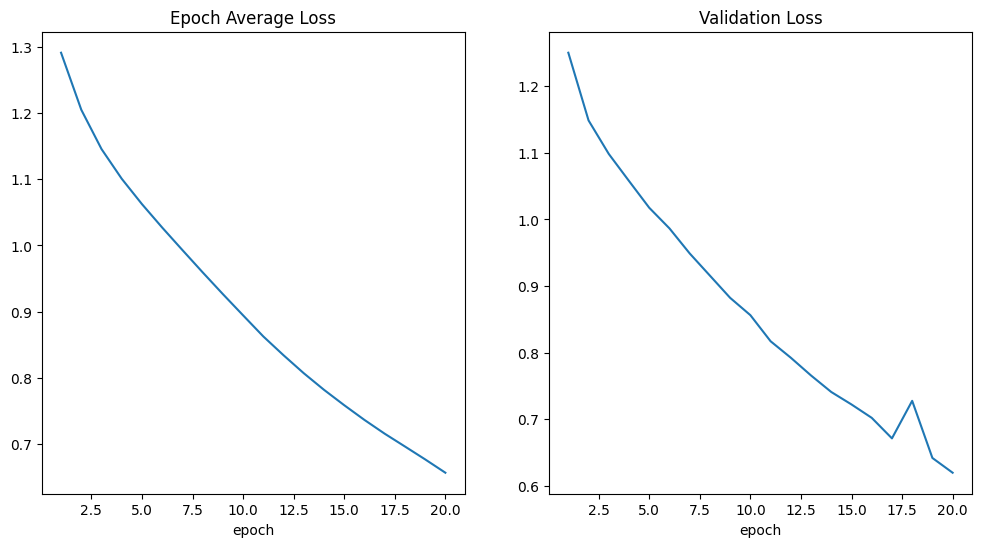

In [26]:
%matplotlib inline
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Validation Loss")
x = [val_interval * (i + 1) for i in range(len(losses_validation))]
y = losses_validation
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

In [27]:
images = []
outputs = []
labels = []
for val_data in val_loader:
    val_inputs, val_labels = (
        val_data["image"].to(device),
        val_data["label"].to(device),
        #val_data["image"].cpu(),
        #val_data["label"].cpu(),
    )
    images.append(val_inputs)
    outputs.append(model(val_inputs))
    labels.append(val_labels)

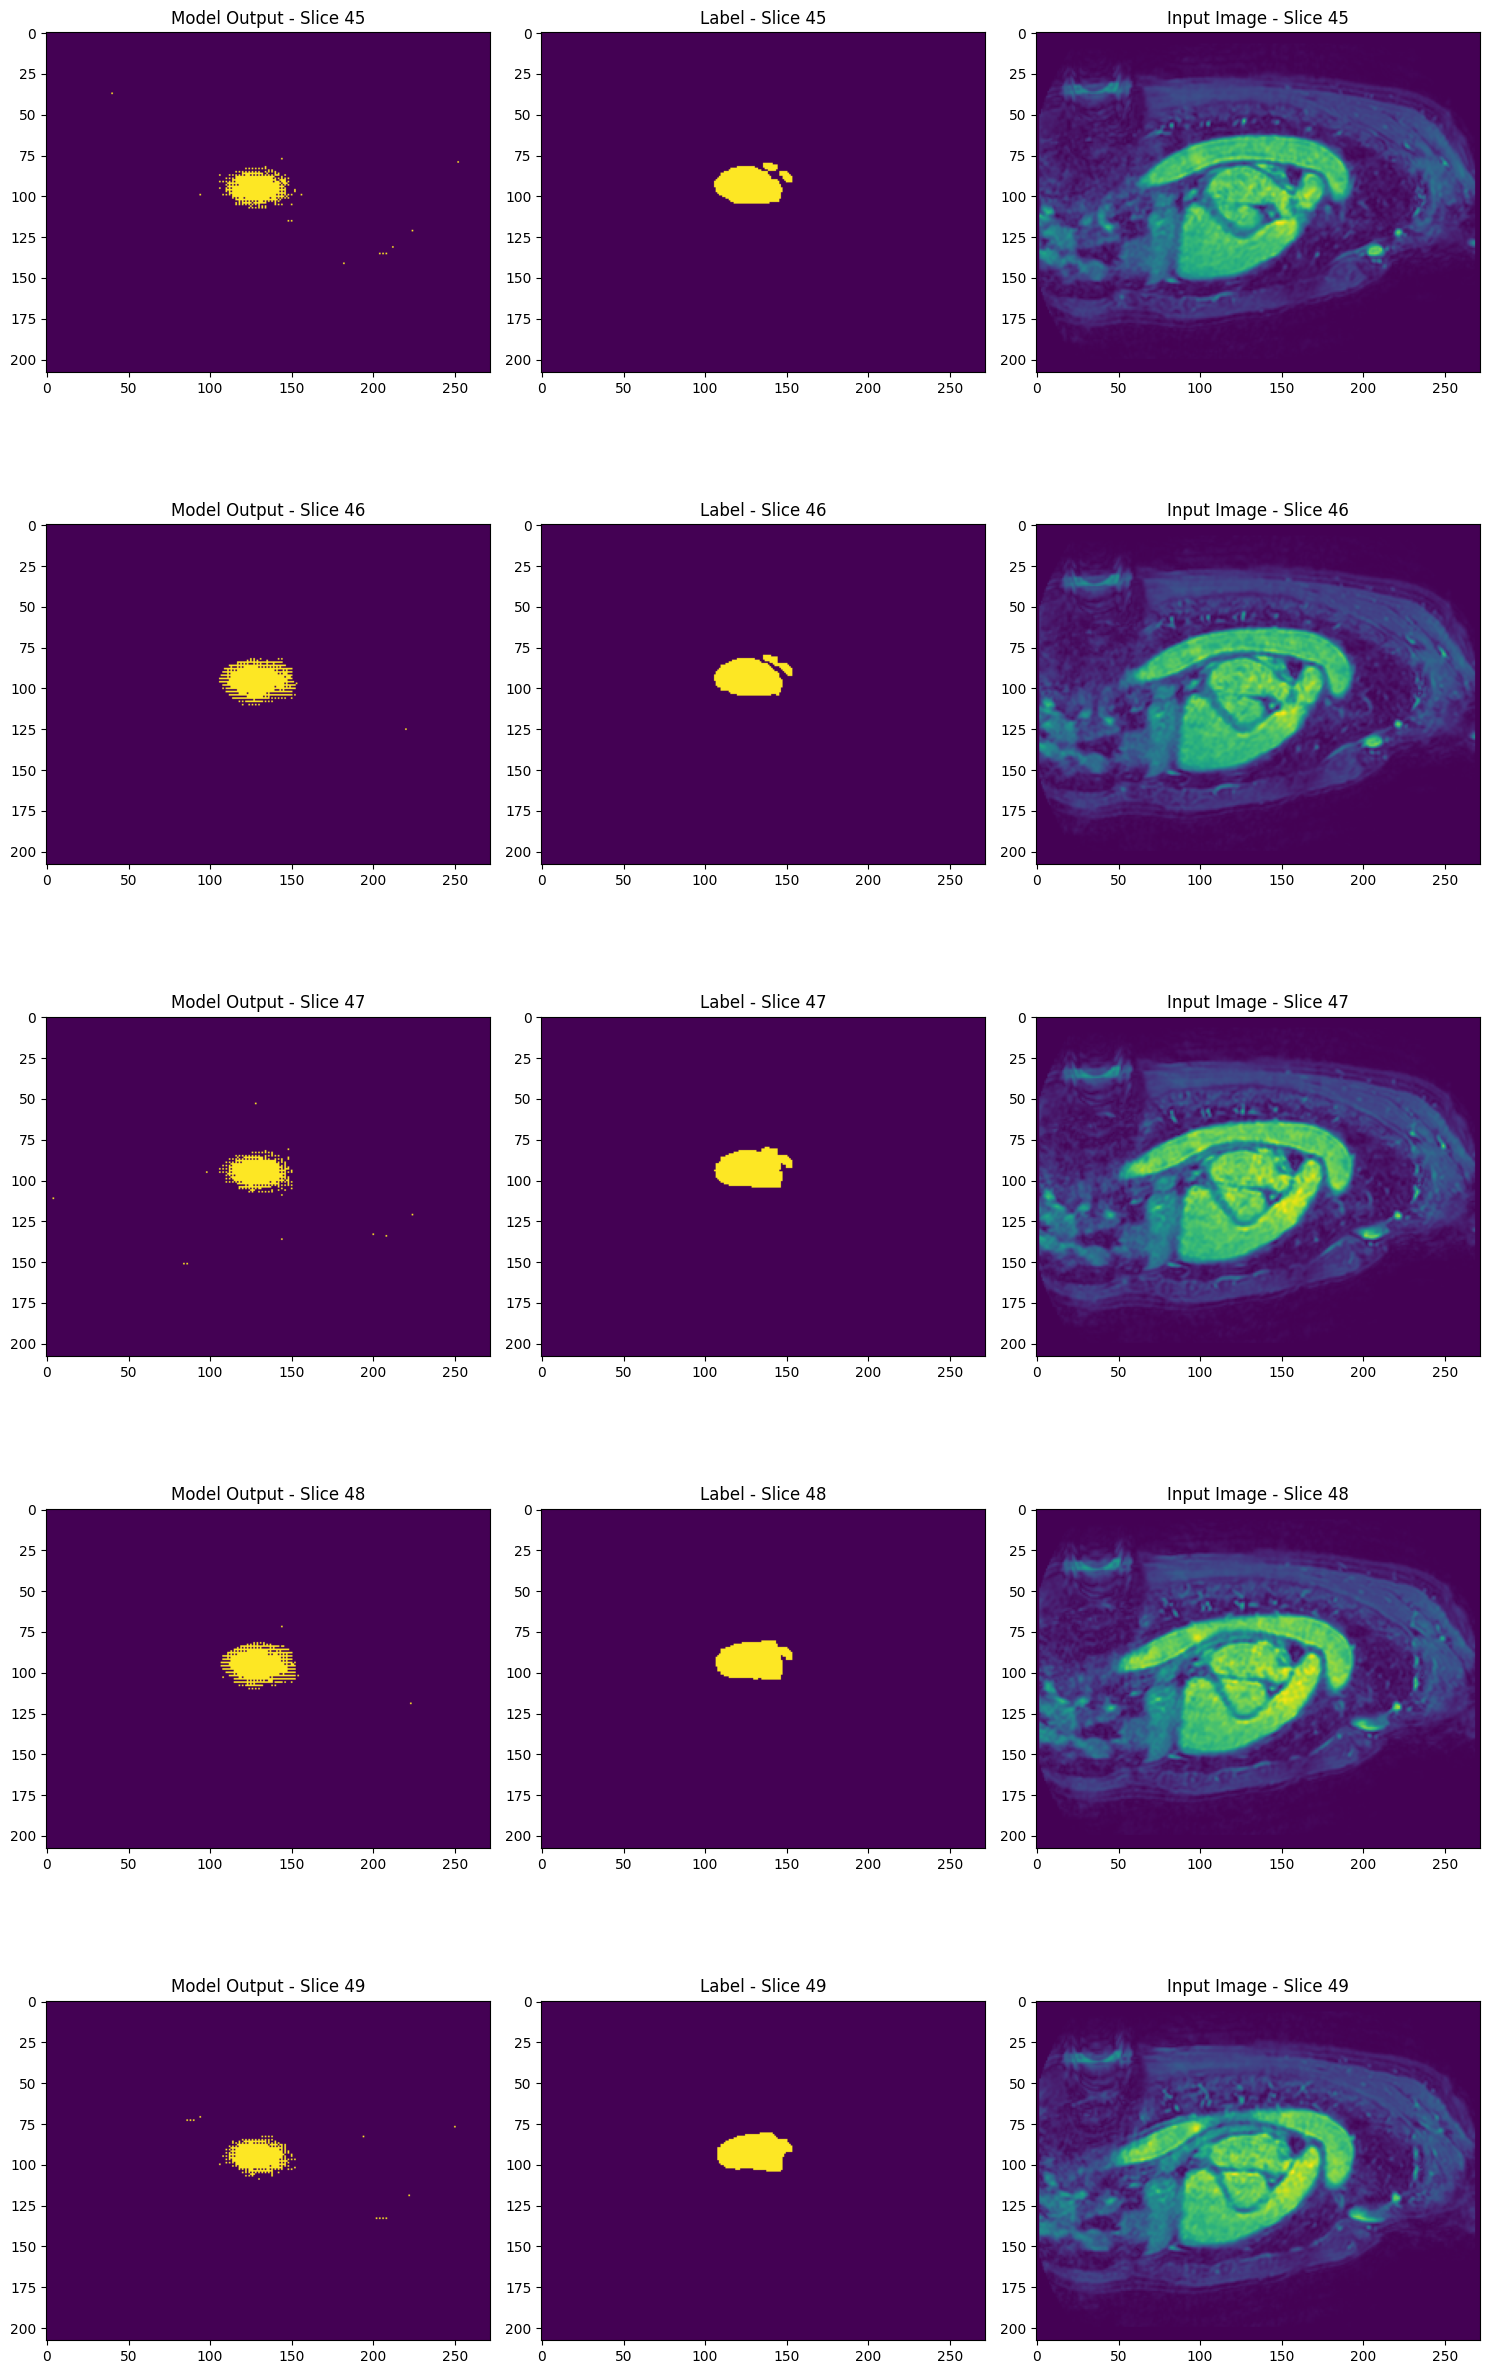

In [28]:
# Assuming outputs, labels, and images are your variables
output = outputs[0]
label = labels[0][0][0]
image = images[0][0][0]

# Set the slice range from 45 to 50
slice_start = 45
slice_end = 50

# Calculate the number of slices
num_slices = slice_end - slice_start

# Create a subplot with 'num_slices' rows and 3 columns
plt.figure(figsize=(15, 5 * num_slices))

for i in range(num_slices):
    # Increment the slice index
    current_slice = slice_start + i

    # Plot the Model Output
    plt.subplot(num_slices, 3, 3 * i + 1)
    with torch.no_grad():
        plt.imshow(torch.argmax(output.cpu(), dim=1)[0, :, :, current_slice])
    plt.title(f'Model Output - Slice {current_slice}')

    # Plot the Label
    plt.subplot(num_slices, 3, 3 * i + 2)
    plt.imshow(label.cpu()[:, :, current_slice])
    plt.title(f'Label - Slice {current_slice}')

    # Plot the Input Image
    plt.subplot(num_slices, 3, 3 * i + 3)
    plt.imshow(image.cpu()[:, :, current_slice])
    plt.title(f'Input Image - Slice {current_slice}')

# Adjust layout for better visualization
plt.tight_layout()

# Show the plots
plt.show()